<a href="https://colab.research.google.com/github/yaelgreen/ML1-Final-project/blob/main/ML1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part 1 - Initial dataset creation

In [11]:
!pip install matplotlib
!pip install numpy

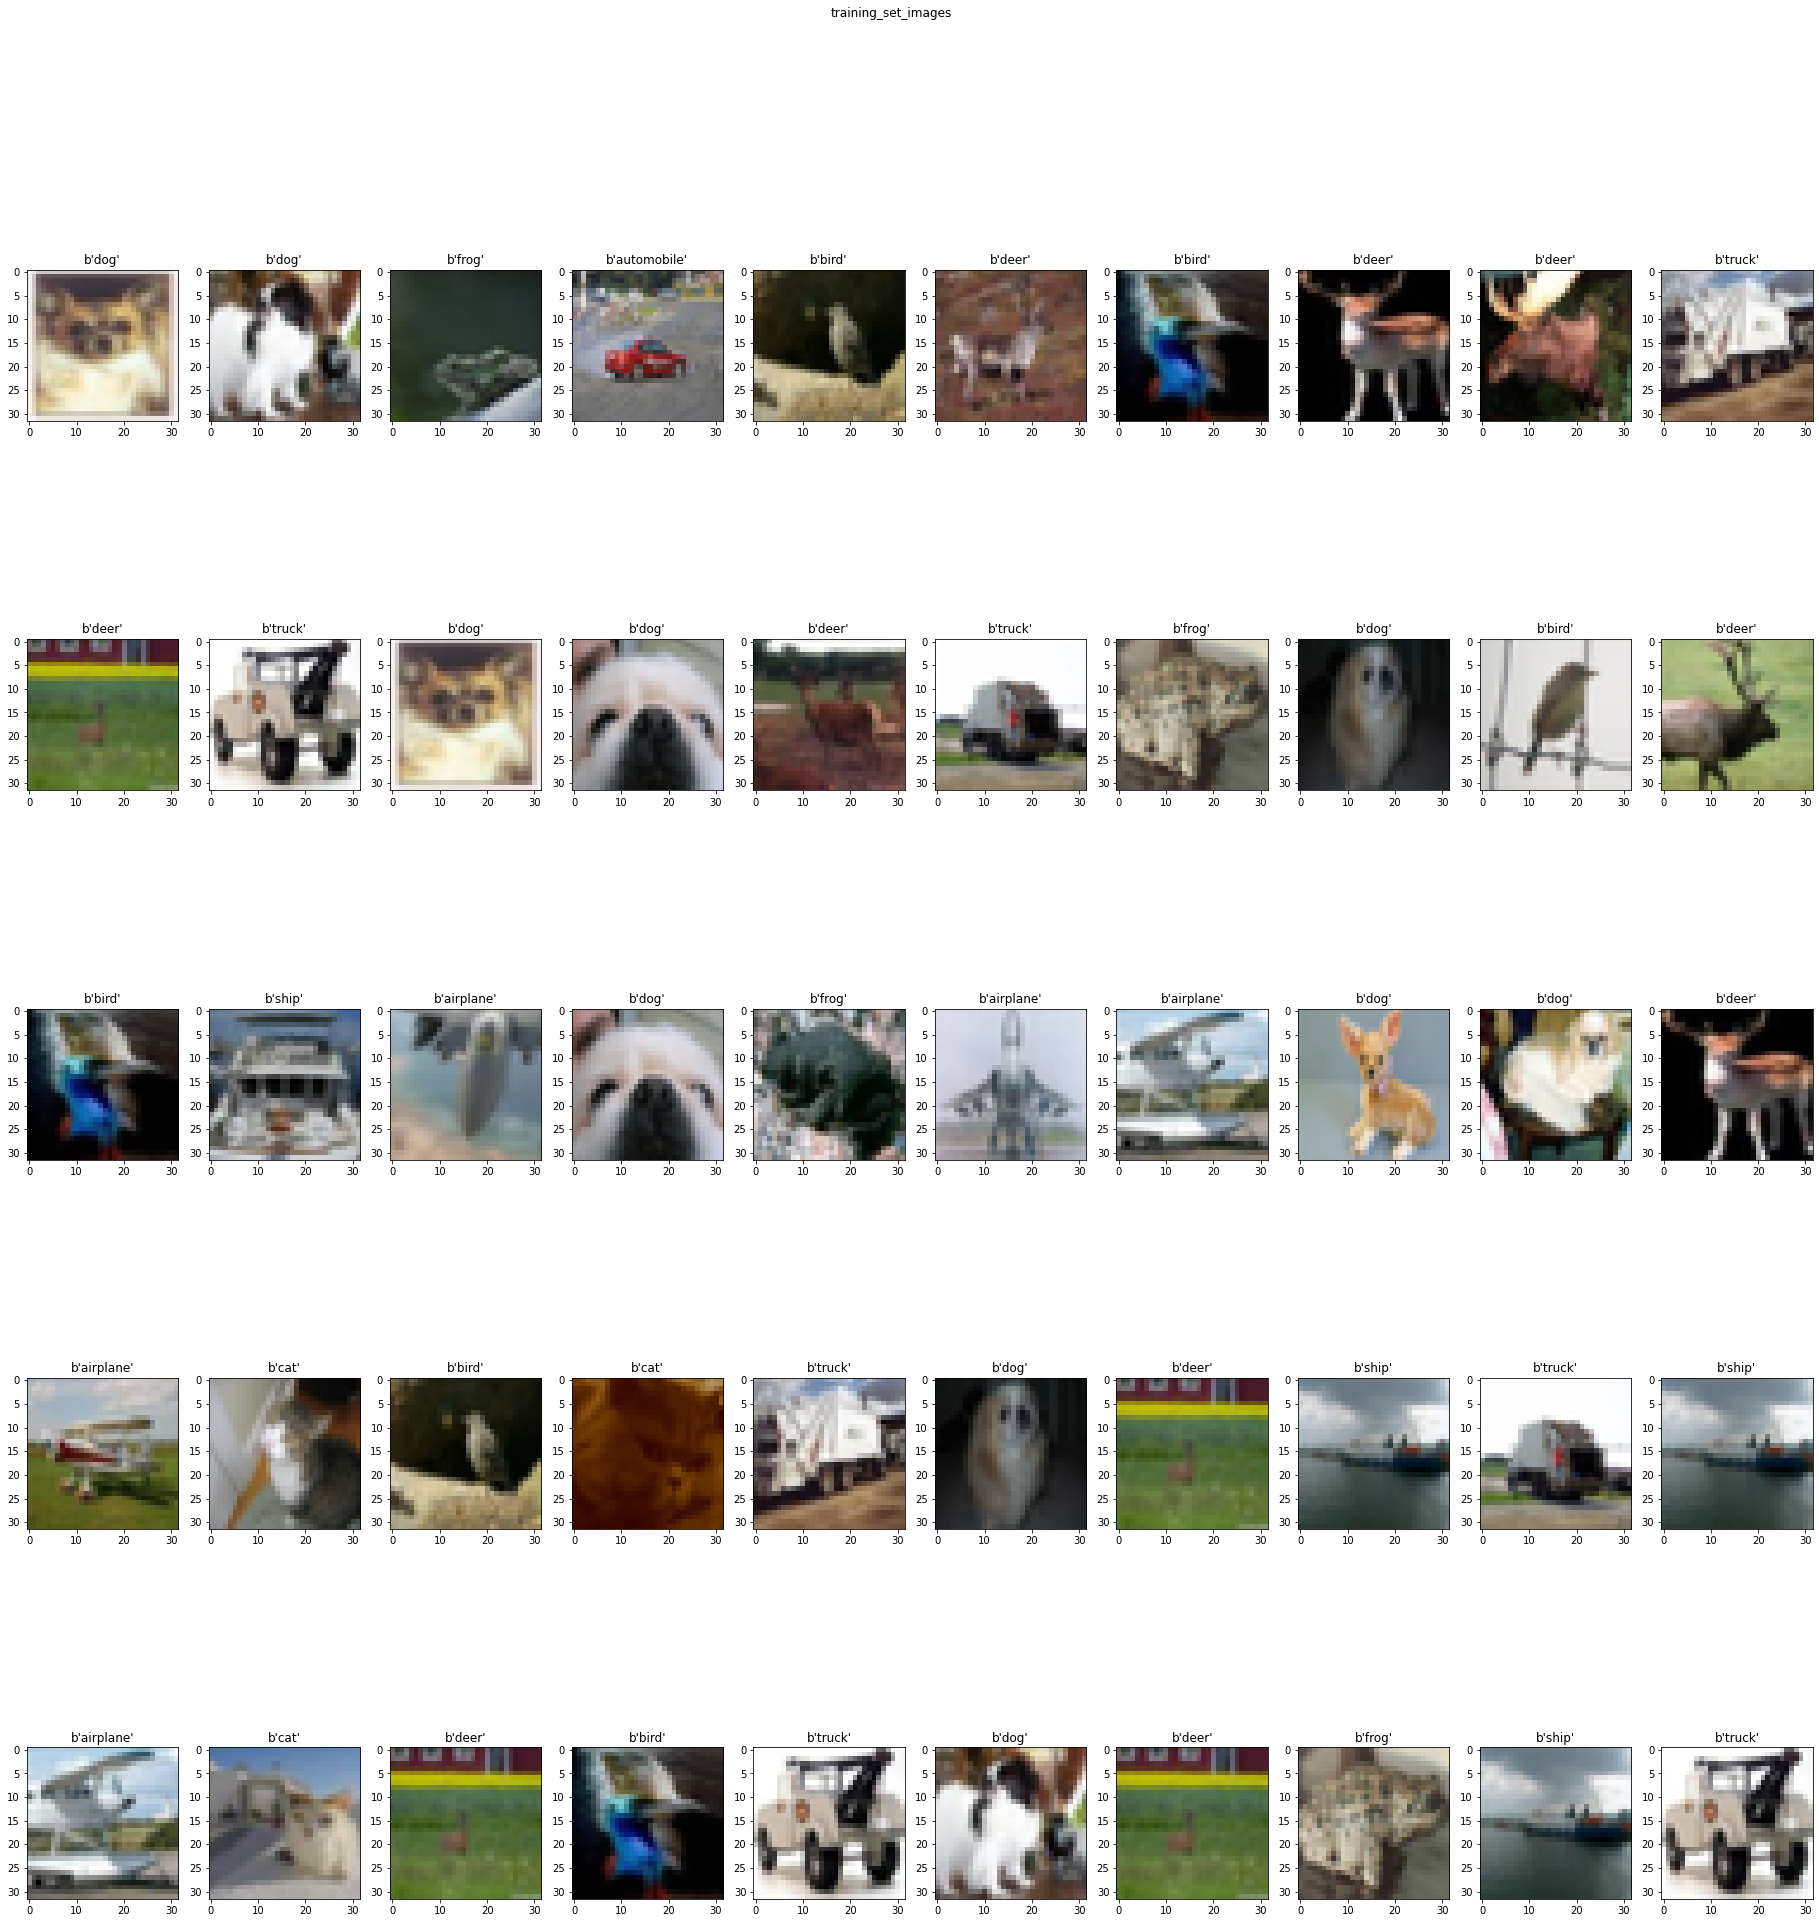

<Figure size 432x288 with 0 Axes>

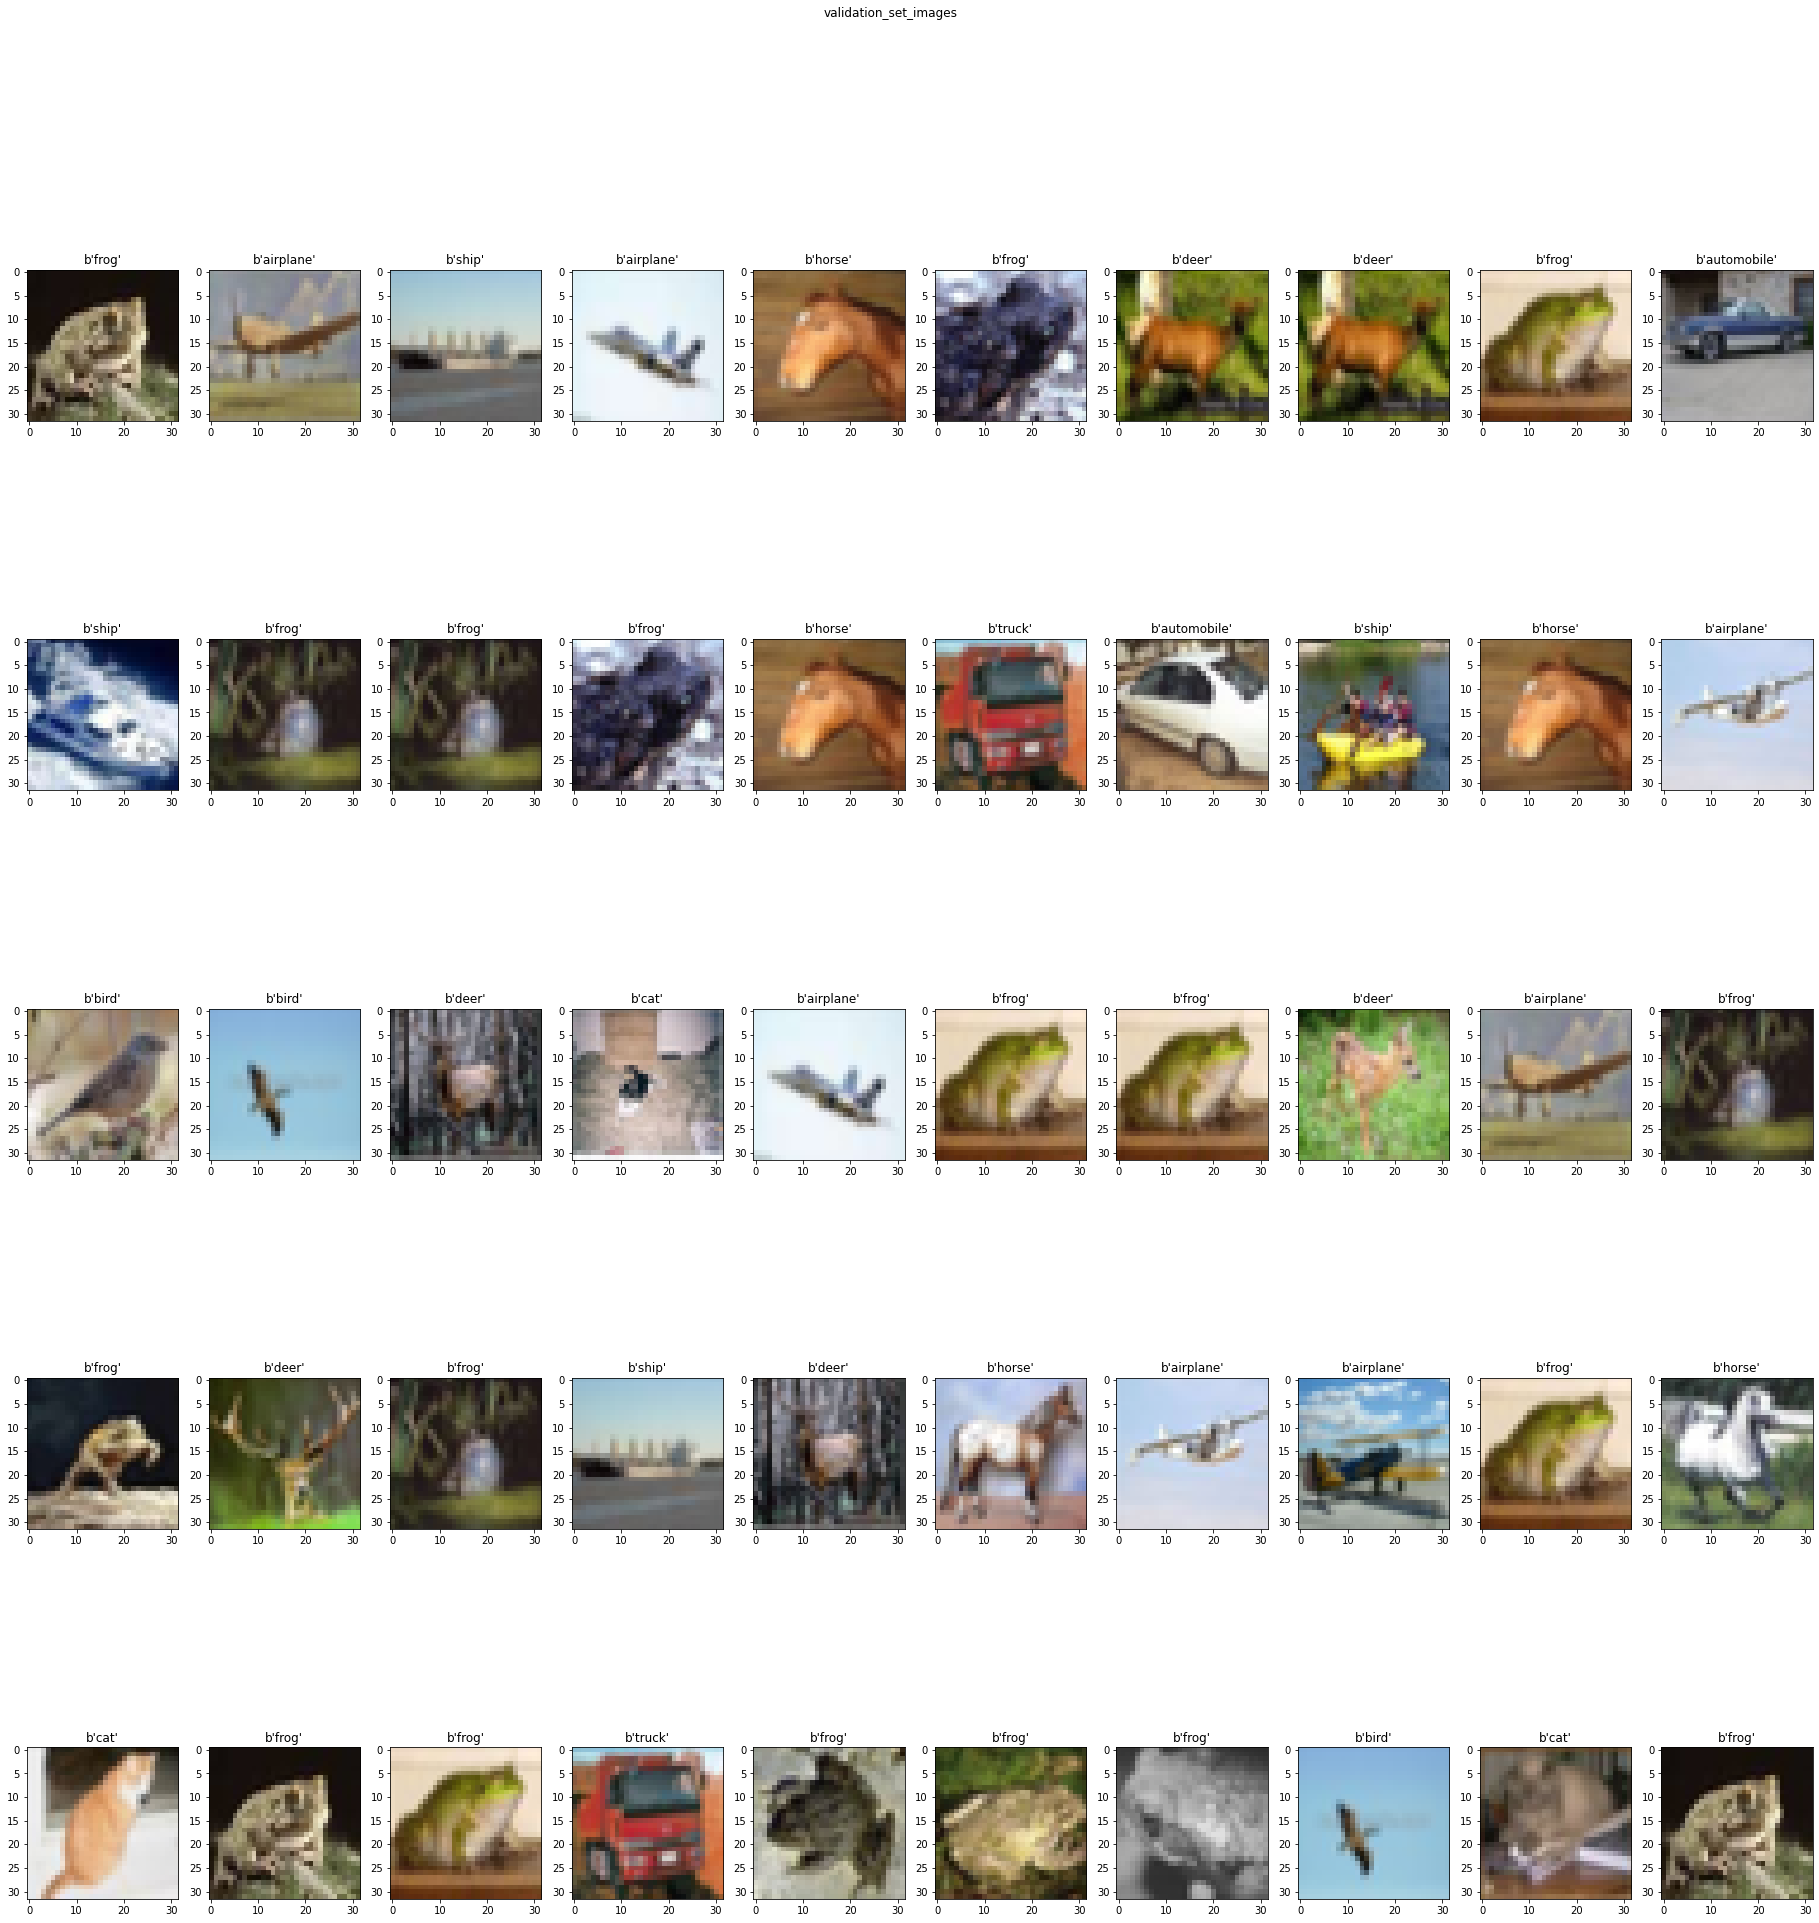

<Figure size 432x288 with 0 Axes>

In [12]:
from typing import Dict, List

import requests
import numpy as np
import matplotlib.pyplot as plt
import os
from random import randint


def subset_of_data_set(data_set, indices):
    return {
        b'batch_label': data_set[b'batch_label'],
        b'labels': [data_set[b'labels'][i] for i in indices],
        b'data': np.take(data_set[b'data'], indices, axis=0),
        b'filenames': [data_set[b'filenames'] for i in indices],
    }


def random_indices(choose: int, out_of: int) -> List[int]:
    return [randint(0, out_of) for i in range(0, choose)]


def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def mapping(x):
    return (-1 + (2 / 255) * x)


def download_and_extract_cifar_10_dataset(
        url: str = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz") -> None:
    filename = "cifar-10-python.tar.gz"

    # Download the CIFAR 10 dataset
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.raw.read())

    # Extract the tar.gz file
    import shutil
    extract_path = "cifar-10"
    shutil.unpack_archive(filename, extract_path)


def create_training_and_validation_sets(training_size: str = 1000) -> \
        (Dict, Dict, Dict):
    # load dataset
    path = os.path.join(os.getcwd(), "cifar-10", "cifar-10-batches-py")
    first_batch = unpickle(os.path.join(path, "data_batch_1"))
    # choose random 1000 images
    indices = random_indices(9999, training_size)
    training_set = subset_of_data_set(first_batch, indices)
    validation_set = unpickle(os.path.join(path, "data_batch_2"))
    meta = unpickle(os.path.join(path, "batches.meta"))
    return training_set, validation_set, meta


def plot_image(data, meta, image_index=0):
    # get image and RGB channels from dataset
    image = data[b'data'][image_index, :]
    image_r = image[0:1024].reshape(32, 32)
    image_g = image[1024:2048].reshape(32, 32)
    image_b = image[2048:].reshape(32, 32)
    # plot image using RGB channels
    img = np.dstack((image_r, image_g, image_b))
    title = meta[b'label_names'][data[b'labels'][image_index]]
    return img, title


def plot_random_images(data_set: Dict, meta: Dict, plt_title="plot",
                       number_of_images: int = 50) -> None:
    # choose random 50 images
    indices = random_indices(999, number_of_images)
    # plot images
    n_col = 10
    n_row = int(number_of_images / n_col)
    imgs = [plot_image(data_set, meta, image_index) for image_index in indices]
    _, axs = plt.subplots(n_row, n_col, figsize=(32, 32))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        ax.imshow(img[0])
        ax.set_title(img[1])
    plt.subplots_adjust(top=0.9)
    plt.suptitle(plt_title)
    plt.show()
    plt.savefig(f"{plt_title}.png")


def convert_pixel_intensity(data_set):
    data_set[b'data'] = np.array([mapping(x) for x in data_set[b'data']])


download_and_extract_cifar_10_dataset()
training_set, validation_set, meta = create_training_and_validation_sets()
plot_random_images(training_set, meta, "training_set_images")
plot_random_images(validation_set, meta, "validation_set_images")
convert_pixel_intensity(training_set)
convert_pixel_intensity(validation_set)

In [13]:
## Part 2

In [15]:
from textwrap import wrap
from typing import Dict
import numpy as np
# from part1 import random_indices, create_training_and_validation_sets, \
#     convert_pixel_intensity
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("error")

training_set_size = 1000
num_of_labels = 10
training_set_shape = 3072  # 1024 * 3


class Model():

    def __init__(self, training_set: Dict,
                 learning_rate: float,
                 num_of_iterations: int,
                 batch_size: int,
                 momentum_coefficient: float,
                 l2_regularization_coefficient: float,
                 standard_deviation: float,
                 model_name: str):
        valid = self.verify_training_input(learning_rate, num_of_iterations,
                                           batch_size, momentum_coefficient,
                                           l2_regularization_coefficient,
                                           standard_deviation)
        if not valid:
            print("One or more of the parameters to the model is invalid")
        self.training_set = training_set
        self.learning_rate = learning_rate
        self.num_of_iterations = num_of_iterations
        self.batch_size = batch_size
        self.momentum_coefficient = momentum_coefficient
        self.l2_regularization_coefficient = l2_regularization_coefficient
        self.standard_deviation = standard_deviation
        self.model_name = model_name
        self.wight_vectors = None
        self.biases = None

    def verify_training_input(self, learning_rate: float,
                              num_of_iterations: int, batch_size: int,
                              momentum_coefficient: float,
                              l2_regularization_coefficient: float,
                              standard_deviation: float):
        valid = True
        if batch_size < 1 or batch_size > training_set_size:
            print(f"Batch size {batch_size} must be an integer between 1 and"
                  f"training set size {training_set_size}")
            valid = False
        if learning_rate < 0:
            print(f"Learning rate {learning_rate} must be an positive float")
            valid = False
        if momentum_coefficient <= 0 or momentum_coefficient >= 1:
            print(f"Momentum Coefficient {momentum_coefficient} must be a"
                  f"float between 1 and 0")
            valid = False
        if l2_regularization_coefficient < 0:
            print(f"L2 regularization coefficient "
                  f"{l2_regularization_coefficient} must be a non negative"
                  f"float")
            valid = False
        if standard_deviation < 0:
            print(f"Standard Deviation {standard_deviation} must be a non"
                  f"negative float")
            valid = False
        if num_of_iterations <= 0:
            print(f"Number of iterations {num_of_iterations} must be a"
                  f"positive int")
            valid = False
        return valid

    def sgd(self):
        # init wight_vectors
        self.wight_vectors = np.random.normal(loc=0, scale=self.standard_deviation,
                                              size=num_of_labels * (training_set_shape + 1))
        self.cross_entropy_losses = {}
        self.hing_losses = {}
        for iteration_number in range(self.num_of_iterations):
            print(f'started {iteration_number} iteration')
            # Random batch
            training_indices = random_indices(self.batch_size, training_set_size)
            v_t = np.zeros(len(self.wight_vectors))
            for training_index in training_indices:
                x = self.training_set[b'data'][training_index]
                y = self.training_set[b'labels'][training_index]
                v_t = self.momentum_coefficient * v_t - (1 - self.momentum_coefficient) * self.learning_rate * self.calc_derivative(x, y)
                self.wight_vectors += v_t
            self.cross_entropy_losses[iteration_number] = self.calc_cross_entropy_loss(self.training_set[b'data'], self.training_set[b'labels'])
            print(f"iteration: {iteration_number} cross entropy losses: {self.cross_entropy_losses[iteration_number]}")
            self.hing_losses[iteration_number] = self.calc_hinge_loss(self.training_set[b'data'], self.training_set[b'labels'])
            print(
                f"iteration: {iteration_number} hing losses: {self.hing_losses[iteration_number]}")
        return self.wight_vectors

    def plot_losses(self):
        fig, axs = plt.subplots(2)
        plt_title = f'cross_entropy_loss_and_hing_loss_for_{self.model_name}'
        fig.suptitle("\n".join(wrap(plt_title, 60)))
        axs[0].plot(list(self.cross_entropy_losses.values()))
        axs[1].plot(list(self.hing_losses.values()))
        # plt.show()
        fig.savefig(f"{plt_title}.png")
        plt.close()

    def training(self) -> None:
        theta = self.sgd()
        with open('result.txt', 'w') as f:
            as_str = ' '.join([str(v) for v in self.wight_vectors])
            f.write(as_str)
        return theta

    def inference_training_set(self):
        # if not self.wight_vectors or not self.biases:
        #     print("You need to train the model before you can run inference")
        inference_result = self.inference(self.training_set[b'data'])
        successes = 0
        for i in range(0, training_set_size):
            if inference_result[i][1] == self.training_set[b'labels'][i]:
                successes += 1
        print(f"number of successes for model {self.model_name}: {successes}")
        return successes

    def single_inference(self, x):
        max_result = None
        prediction_label = 0
        class_score = []
        for j in range(num_of_labels):
            theta, b = self.get_theta_b_i(j)
            result = np.inner(theta, x) + b
            class_score.append(result)
            max_result = result if not max_result else max(result, max_result)
            prediction_label = j if result == max_result else prediction_label
        return class_score, prediction_label

    def inference(self, set_of_instances: np.ndarray) -> np.ndarray:
        result = {}
        for i in range(set_of_instances.shape[0]):
            class_score, prediction_label = self.single_inference(set_of_instances[i])
            result[i] = (class_score, prediction_label)
        return result

    def get_theta_b_i(self, i):
        theta_i = self.wight_vectors[i:i + training_set_shape]
        b_i = self.wight_vectors[i + training_set_shape]
        return theta_i, b_i

    def calc_hinge_loss(self, training_set_data, training_set_labels):
        loss = 0
        for i in range(0, training_set_size):
            x = training_set_data[i]
            y = training_set_labels[i]
            cur_loss = 0
            r, prediction_label = self.single_inference(x)
            for label in range(0, num_of_labels):
                cur_loss = max(cur_loss, r[label] - r[y] + 1 if label != y else 0)
            loss += cur_loss
        return loss

    def calc_cross_entropy_loss(self, training_set_data, training_set_labels):
        loss = 0
        for i in range(0, training_set_size):
            x = training_set_data[i]
            y = training_set_labels[i]
            r, _ = self.single_inference(x)
            sum = 0
            for j in range(num_of_labels):
                sum += np.exp(r[j])
            loss += np.log(sum) - r[y]
        return loss

    def calc_exp(self, theta_i, b_i, x):
        try:
            return np.exp(np.inner(theta_i, x) + b_i)
        except RuntimeWarning:
            print(f"{theta_i=}")
            print(f"{x=}")
            print(f"{b_i=}")

    def calc_exp_sum(self, x):
        sum = 0
        for j in range(num_of_labels):
            theta_j, b_j = self.get_theta_b_i(j)
            try:
                exp = self.calc_exp(theta_j, b_j, x)
                sum += exp
            except (RuntimeWarning, TypeError):
                print(f"{theta_j=}")
                print(f"{x=}")
                print(f"{b_j=}")
                print(f"{exp}=")
        return sum

    def calc_derivative(self, x, y):
        vector = []
        r = [0] * num_of_labels
        r[y] = 1

        for i in range(num_of_labels):
            theta_i, b_i = self.get_theta_b_i(i)
            r_i = r[i]
            for j in range(training_set_shape):
                x_j = x[j]
                try:
                    derivative = x_j * (self.calc_exp(theta_i, b_i, x) / self.calc_exp_sum(x) - r_i) + 2 * self.l2_regularization_coefficient * theta_i[j]
                except RuntimeWarning:
                    print(f"{theta_i=}")
                    print(f"{x=}")
                    print(f"{b_i=}")
                    print(f"{r_i=}")
                    print(self.calc_exp(theta_i, b_i, x))
                    print(self.calc_exp_sum(x))
                vector.append(derivative)
            derivative_b = (self.calc_exp(theta_i, b_i, x) / self.calc_exp_sum(x) ) - r_i
            vector.append(derivative_b)
        return np.array(vector)



training_set, validation_set, meta = create_training_and_validation_sets()
convert_pixel_intensity(training_set)
convert_pixel_intensity(validation_set)
learning_rate = [0.01, 0.1, 0.5]
num_of_iterations = 50
batch_size = [10, 20, 30]
momentum_coefficient = [0.2, 0.3, 0.5]
l2_regularization_coefficient = [0.4, 0.5, 0.6]
standard_deviation = [0.5, 1, 1.5]
for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                for m in range(3):
                    model_name = f"learning rate {learning_rate[i]} number of iterations {num_of_iterations}"\
                                 f" batch_size {batch_size[j]} momentum coefficient {momentum_coefficient[k]} "\
                                 f"l2 regularization coefficient {l2_regularization_coefficient[l]}" \
                                 f"standard_deviation {standard_deviation[m]}"
                    print(model_name)
                    model = Model(training_set, learning_rate[i], num_of_iterations, batch_size[j],
                                  momentum_coefficient[k], l2_regularization_coefficient[l],
                                  standard_deviation[m], model_name.replace(" ", "_").replace(".", "_"))
                    model.training()
                    model.plot_losses()
                    model.inference_training_set()


learning rate 0.01 number of iterations 50 batch_size 10 momentum coefficient 0.2 l2 regularization coefficient 0.4standard_deviation 0.5
started 0 iteration


KeyboardInterrupt: 

In [16]:
## Part 3

In [17]:
from textwrap import wrap

import numpy as np
import matplotlib.pyplot as plt

# from part1 import create_training_and_validation_sets, convert_pixel_intensity, \
#     plot_random_images
# from part2 import Model


def instance_dimension_reduction(data_set, d):
    for index in range(data_set[b'data'].shape[0]):
        img = data_set[b'data'][index]
        img_r = img[0:1024].reshape(32, 32)
        img_g = img[1024:2048].reshape(32, 32)
        img_b = img[2048:].reshape(32, 32)
        img_r_new = np.zeros((32, 32))
        img_g_new = np.zeros((32, 32))
        img_b_new = np.zeros((32, 32))
        for i in range(33 - d):
            for j in range(33 - d):
                r_average = []
                g_average = []
                b_average = []
                for k in range(d):
                    r_average.append(img_r[i+k, j:j+d])
                    g_average.append(img_g[i + k, j:j + d])
                    b_average.append(img_b[i + k, j:j + d])
                r = np.average(r_average)
                g = np.average(g_average)
                b = np.average(b_average)
                img_r_new[i, j] = r
                img_g_new[i, j] = g
                img_b_new[i, j] = b
        new_img = np.concatenate((img_r_new.flatten(), img_g_new.flatten(),
                                  img_b_new.flatten()))
        data_set[b'data'][index] = new_img
    return data_set


def plot_hinge_loss_vs_model_capacity(losses, model_name):
    fig, axs = plt.subplots(2)
    plt_title = f'hing_loss_vs_model_capacity_for_{model_name}'
    fig.suptitle("\n".join(wrap(plt_title, 60)))
    axs[0].plot(list(losses['training'].values()))
    axs[1].plot(list(losses['validation'].values()))
    # plt.show()
    fig.savefig(f"{plt_title}.png")


def main_part_3(training_set, validation_set, meta):
    # For regularization
    # optimize over the training set
    convert_pixel_intensity(training_set)
    convert_pixel_intensity(validation_set)
    batch_size = 30
    learning_rate = 0.1
    num_of_iterations = 30
    momentum_coefficient = 0.3
    standard_deviation = 1
    l2_regularization = [0.05, 0.5, 1]
    losses = {'training': {}, 'validation': {}}
    for l in l2_regularization:
        model_name = f"l2_regularization_{l2_regularization}"
        model = Model(training_set, learning_rate, num_of_iterations,
                      batch_size, momentum_coefficient, l, standard_deviation,
                      model_name)
        model.training()
        # measure the classification error
        losses['training'][l] = model.hing_losses[num_of_iterations-1]
        losses['validation'][l] = model.calc_hinge_loss(validation_set[b'data'], validation_set[b'labels'])
        print(losses)
        # generate a plot showing training and validation errors vs. model capacity
        plot_hinge_loss_vs_model_capacity(losses, model_name)

    # For instance dimension reduction
    # optimize over the training set
    training_set, validation_set, meta = create_training_and_validation_sets()
    convert_pixel_intensity(training_set)
    convert_pixel_intensity(validation_set)
    l2_regularization = 0.5
    dimension_reduction = [2, 3, 4]
    losses = {'training': {}, 'validation': {}}
    for d in dimension_reduction:
        model_name = f"dimension_reduction_{d}"
        training_set_dim_d = instance_dimension_reduction(training_set, d)
        model = Model(training_set_dim_d, learning_rate, num_of_iterations,
                      batch_size, momentum_coefficient, l2_regularization,
                      standard_deviation,
                      model_name)
        model.training()
        # measure the classification error
        losses['training'][d] = model.hing_losses[num_of_iterations - 1]
        validation_set_dim_d = instance_dimension_reduction(validation_set, d)
        losses['validation'][d] = model.calc_hinge_loss(
            validation_set_dim_d[b'data'], validation_set_dim_d[b'labels'])
        print(losses)
        # generate a plot showing training and validation errors vs. model capacity
        plot_hinge_loss_vs_model_capacity(losses, model_name)



training_set, validation_set, meta = create_training_and_validation_sets()
main_part_3(training_set, validation_set, meta)

started 0 iteration


KeyboardInterrupt: 

In [18]:
## part 4

In [19]:
import math
# from part1 import create_training_and_validation_sets, plot_image, \
#     convert_pixel_intensity
# from part2 import Model
# import part2
import matplotlib.pyplot as plt
import numpy as np

# from part3 import plot_hinge_loss_vs_model_capacity

weight = height = 32
counter = 0

def to_greyscale(img):
    return np.average(img, axis=2)

def calc_gradient_images(img):
    global counter
    print(counter)
    counter += 1
    img = to_greyscale(img)
    new_img = []
    magnitudes = []
    angles = []
    for i in range(height):
        for j in range(weight):
            gx = img[i, min(height-1, j+1)] - img[i, max(0, j-1)]
            gy = img[max(0, i-1), j] - img[min(weight-1, i+1), j]
            magnitude = math.sqrt(pow(gx, 2) + pow(gy, 2))
            magnitudes.append(magnitude)
            angle = math.degrees(0.0) if gx == 0 else abs(math.atan(gy/gx))
            angles.append(angle)
    new_img.extend(magnitudes)
    new_img.extend(angles)
    return np.array(new_img)

def hogify(image_set):
    images = []
    for img in image_set:
        image_r = img[0:1024].reshape(32, 32)
        image_g = img[1024:2048].reshape(32, 32)
        image_b = img[2048:].reshape(32, 32)
        img = np.dstack((image_r, image_g, image_b))
        images.append(img)
    return [calc_gradient_images(img) for img in images]

def main_part_4(training_set, validation_set, meta):
    training_set[b'data'] = hogify(training_set[b'data'])
    validation_set[b'data'] = hogify(validation_set[b'data'])
    batch_size = 30
    learning_rate = 0.1
    num_of_iterations = 30
    momentum_coefficient = 0.3
    standard_deviation = 1
    l2_regularization = 0.5
    losses = {'training': {}, 'validation': {}}
    model_name = f"HOG"
    part2.training_set_shape = 32*32*2
    convert_pixel_intensity(training_set)
    convert_pixel_intensity(validation_set)
    model = Model(training_set, learning_rate, num_of_iterations,
                  batch_size, momentum_coefficient, l2_regularization,
                  standard_deviation, model_name)
    model.training()
    # measure the classification error
    losses['training'] = model.hing_losses[num_of_iterations-1]
    losses['validation'] = model.calc_hinge_loss(validation_set[b'data'], validation_set[b'labels'])
    print(losses)


training_set, validation_set, meta = create_training_and_validation_sets()
main_part_4(training_set, validation_set, meta)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953


KeyboardInterrupt: 

In [20]:
## Part 5

In [22]:
# from part1 import create_training_and_validation_sets
# from part3 import main_part_3
# from part4 import main_part_4


def main_part5():
    training_set, validation_set, meta = create_training_and_validation_sets(10000)
    main_part_3(training_set, validation_set, meta)
    main_part_4(training_set, validation_set, meta)


main_part5()

IndexError: list index out of range

In [23]:
## part 6

In [24]:
import os
from typing import Dict

# from part1 import create_training_and_validation_sets, convert_pixel_intensity, \
#     unpickle
# from part2 import Model


def create_training_and_testing_sets() -> (Dict, Dict, Dict):
    # load dataset
    path = os.path.join(os.getcwd(), "cifar-10", "cifar-10-batches-py")
    batches = {}
    for i in range(1, 6):
        batch = unpickle(os.path.join(path, f"data_batch_{i}"))
        batches[i] = batch
    training_set = {
        b'batch_label': b'batches 1 to 5',
        b'labels': [label for i, batch in batches.items() for label in batch[b'labels']],
        b'data': [label for i, batch in batches.items() for label in batch[b'data']],
        b'filenames': [label for i, batch in batches.items() for label in batch[b'filenames']],
    }
    test_set = unpickle(os.path.join(path, "test_batch"))
    meta = unpickle(os.path.join(path, "batches.meta"))
    return training_set, test_set, meta


training_set, test_set, meta = create_training_and_testing_sets()
convert_pixel_intensity(training_set)
convert_pixel_intensity(test_set)
learning_rate = 0.01
num_of_iterations = 50
batch_size = 10
momentum_coefficient = 0.3
l2_regularization_coefficient = 0.4
standard_deviation = 0.5
model_name = f"learning rate {learning_rate} number of iterations {num_of_iterations}" \
             f" batch_size {batch_size} momentum coefficient {momentum_coefficient} " \
             f"l2 regularization coefficient {l2_regularization_coefficient}" \
             f"standard_deviation {standard_deviation}"
model = Model(training_set, learning_rate, num_of_iterations,
              batch_size,
              momentum_coefficient, l2_regularization_coefficient,
              standard_deviation,
              model_name.replace(" ", "_").replace(".", "_"))
model.training()
model.plot_losses()

started 0 iteration


KeyboardInterrupt: 